# Libraries yg di gunakan


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, precision_score
from sklearn.metrics import roc_auc_score, f1_score

# Load data

In [ ]:
df = pd.read_csv('gojek_review.csv')

# Exploratory data analisis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userName    225002 non-null  object
 1   content     225000 non-null  object
 2   score       225002 non-null  int64 
 3   at          225002 non-null  object
 4   appVersion  225002 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.6+ MB


In [ ]:
# menghapus kolom nama
df = df.drop(columns=['userName'])

In [ ]:
df.head()

,content,score,at,appVersion
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Mantap,5,2022-01-15 10:05:27,4.9.3


In [ ]:
# Remove neutral review
df = df[df['score'] != 3]

In [ ]:
# Mengganti score menjadi sentimen(positive, negative, dan neutral)
target_map = {
    1 : "negative",
    2 : "negative",
    4 : "positive",
    5 : "positive"
}

df['target'] = df['score'].map(target_map)
# Membuat kolom binery

target_map_biner = {
    "negative" : 0,
    "positive" : 1
}

df['target_biner'] = df['target'].map(target_map_biner)

In [ ]:
df.head()

,content,score,at,appVersion,target,target_biner
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1


In [ ]:
# menggabti nama kolom
df.columns = ['text', 'score', 'date', 'app_version', 'target', 'target_binery']

In [ ]:
df['app_version_cut'] = df['app_version'].str[:3]

In [ ]:
df.head()

,text,score,date,app_version,target,target_binery,app_version_cut
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9


<Axes: xlabel='target', ylabel='count'>

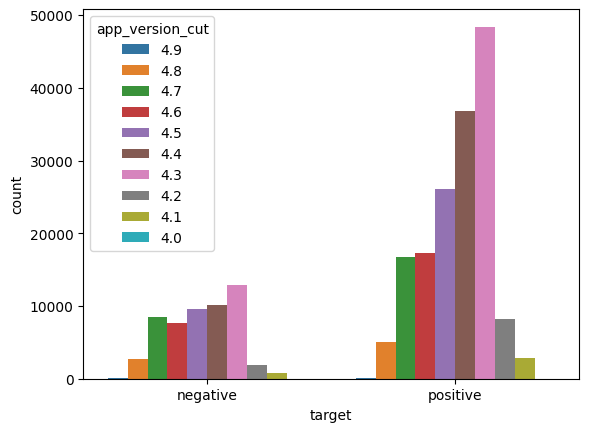

In [ ]:
# visualisasi
sns.countplot(x='target', data=df, hue='app_version_cut')

terlihat hasil visualisasi banyak yg merespon positive

In [ ]:
df = df[df['app_version_cut'] >= '4.7']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32969 entries, 0 to 34575
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             32969 non-null  object
 1   score            32969 non-null  int64 
 2   date             32969 non-null  object
 3   app_version      32969 non-null  object
 4   target           32969 non-null  object
 5   target_binery    32969 non-null  int64 
 6   app_version_cut  32969 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB


<ipython-input-31-10d21462837d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='pastel')


<Axes: xlabel='target', ylabel='count'>

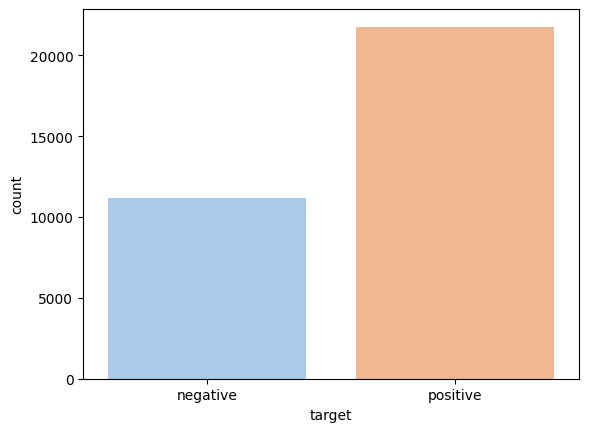

In [ ]:
sns.countplot(x='target', data=df, palette='pastel')

# Text Preprocessing

In [ ]:
!pip install nlp-id

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 31.9 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153892 sha256=5a936c5ef61b7e9d3123cd90bf6e85828d604780cb94cf7799ee951537c9859a
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2e1d1c88a785cd3b10bc8e22f68d219fb17f98cf3ea4d3c4f2dab567f1343f9f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built nlp-id wget
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling pytest-7.4.4:
      Successfully uninstalled pytest-7.4.4


In [ ]:
!pip install indoNLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
import nltk
from nlp_id.lemmatizer import Lemmatizer
from indoNLP.preprocessing import replace_slang, replace_word_elongation
# nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
lemmatizer = Lemmatizer()
df['text_processed'] = df['text'].apply(lemmatizer.lemmatize)

In [ ]:
lemmatizer.lemmatize("menyusup lalu mengendap menyerupai bayangan")

'susup lalu endap rupa bayang'

In [ ]:
df['text_processed'] = df['text_processed'].apply(replace_slang)

In [ ]:
# example
replace_slang("emg siapa yg nanya?")

'memang siapa yang bertanya?'

In [ ]:
df['text_processed'] = df['text_processed'].apply(replace_word_elongation)

In [ ]:
replace_word_elongation("ayoooo semangattt kamuuu bisaaaa")

'ayo semangat kamu bisa'

In [ ]:
def tokenize_text(text):
    # removing extra whitespaces "   halo  " into "halo"
    text = text.strip()
    tokens = nltk.word_tokenize(text)
    # removing any number and symbol tokens
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

def remove_stopword(tokens):
    # removing common words such as "saya"
    stopwords = nltk.corpus.stopwords.words('indonesian')
    tokens = [token for token in tokens if token not in stopwords]
    return tokens
df['tokens'] = df['text_processed'].apply(tokenize_text)
df['tokens_without_stopword'] = df['tokens'].apply(remove_stopword)

In [ ]:
df['text_processed'] = df['tokens_without_stopword'].apply(" ".join)

In [ ]:
df.head()

,text,score,date,app_version,target,target_binery,app_version_cut,text_processed,tokens,tokens_without_stopword
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]"
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b..."
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa..."
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap]
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus]


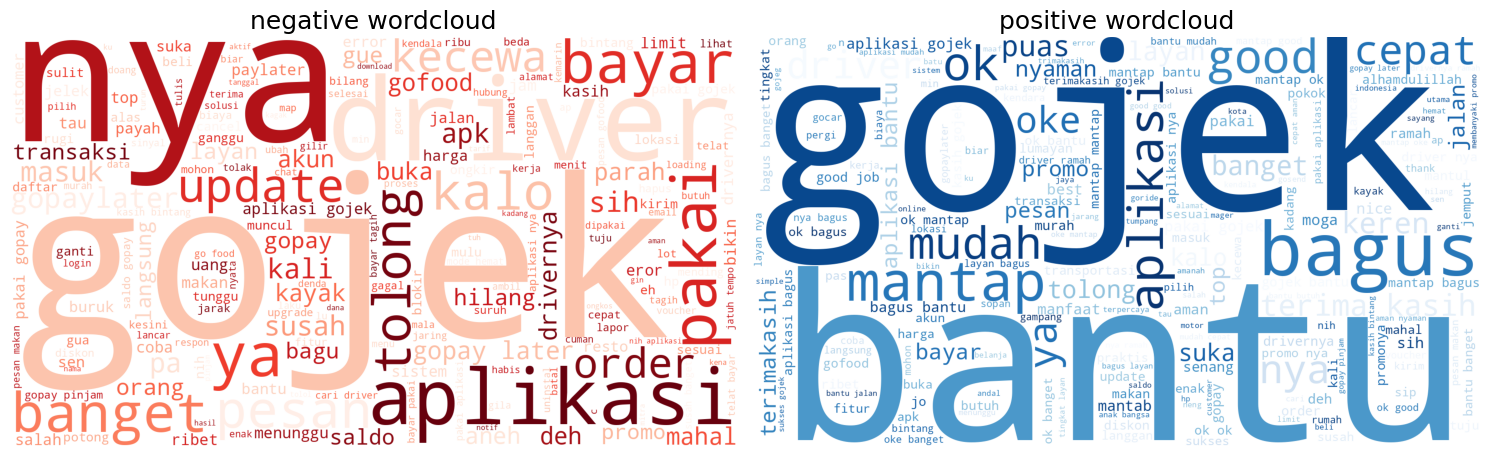

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# daftar sentimen
sentiment_list = ['negative', 'positive']
# daftar warna
colormap_list = ['Reds_r', 'Blues_r']
# list kata yg akan diabaikan
stopwords_set = set(STOPWORDS)

# membuat figure dan axis
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

# looping
for i, (sentiment_list, colormap_list) in enumerate(zip(sentiment_list, colormap_list)):
  # membuat teks konten dari tweet untuk sentiment tertentu
  text = ' '.join(text for text in df[df['target'] == sentiment_list]['text_processed'])
  # membuat wordcloud dari text yg di hasilkan
  wc = WordCloud(background_color='white', colormap=colormap_list, stopwords=stopwords_set, width=1600, height=900).generate(text)
  # menampilkan plot
  ax[i].imshow(wc)
  ax[i].set_title(sentiment_list + " wordcloud", fontsize=18)
  ax[i].axis('off')

fig.tight_layout()

# Data Split

In [ ]:
# Fitur(X) dan target(y)
X = df['text_processed']
y = df['target_binery']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Transforming words into vector, only keep 3000 most common words
vectorizer = TfidfVectorizer(max_features=3000)

In [ ]:
X_train= vectorizer.fit_transform(X_train)

In [ ]:
X_test = vectorizer.transform(X_test)

In [ ]:
X_test

<10880x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 47989 stored elements in Compressed Sparse Row format>

# Model

In [73]:
log = LogisticRegression()
log.fit(X_train, y_train)
print("Model: Logistic Regression")
print("Train acc:", log.score(X_train, y_train))
print("Test acc:", log.score(X_test, y_test))

Model: Logistic Regression
Train acc: 0.9181945764860338
Test acc: 0.9049632352941176


In [75]:
pr_train = log.predict_proba(X_train)[:, 1]
pr_test = log.predict_proba(X_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, pr_train))
print("Test AUC:", roc_auc_score(y_test, pr_test))

Train AUC: 0.9645996746360785
Test AUC: 0.9587081041912844


In [77]:
def report(model):
  preds = model.predict(X_test)
  print(classification_report(y_test, preds, target_names=['negative', 'positive']))
  # confusion_matrix
  cm = confusion_matrix(y_test, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  # plot confusion_matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
  disp.plot();

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      3674
    positive       0.93      0.93      0.93      7206

    accuracy                           0.90     10880
   macro avg       0.89      0.89      0.89     10880
weighted avg       0.91      0.90      0.91     10880



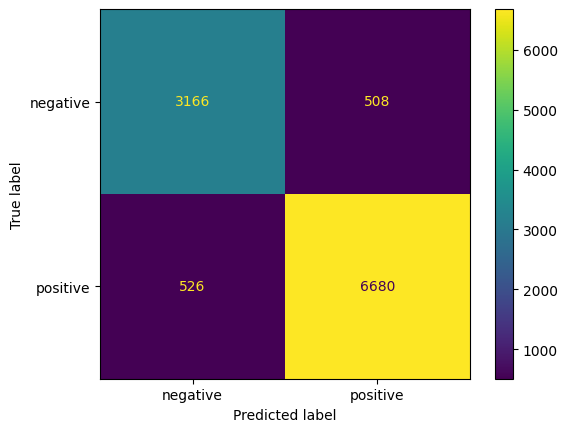

In [78]:
report(log)

- Model ini cukup baik dalam meprediksi kelas positif terbukti dengan
  precession, recall, dan f1-score yg tinggi
- akurasi keseluruhan adalah 90%, tetapi memprtimbangkan ketidakseimbangan kelas, weighted average f1-score 91% memungkinan evaluasi yg lebih komperhensif terhadap kinerja model

In [79]:
# weight for each vocabulary
log.coef_.shape

(1, 3000)

In [80]:
log.coef_

array([[ 0.00354154, -0.60764083,  0.6883025 , ...,  0.24219648,
        -0.7658937 , -0.58034309]])

<Axes: ylabel='Count'>

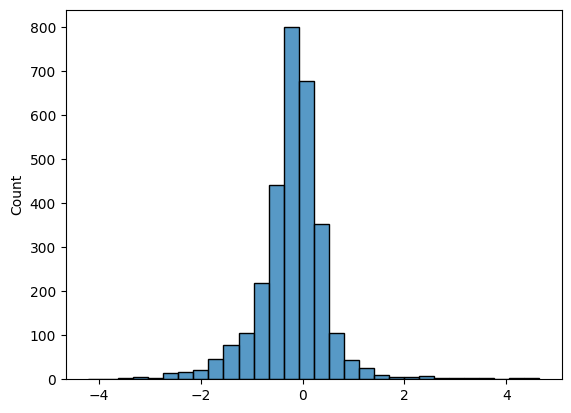

In [81]:
sns.histplot(log.coef_[0], bins=30)

Kebanyakan kata berbobot sekitar 0. Semakin rendah bobotnya maka semakin membuat kalimatnya menjadi negatif dan sebaliknya

In [82]:
word_index_map = vectorizer.vocabulary_

In [83]:
word_index_map['gopay']

934

In [84]:
threshold = 2.5
print("Most positive words:")
for word, index in word_index_map.items():
    weight = log.coef_[0][index]
    if weight > threshold:
        print(word, weight)

Most positive words:
cepat 3.1147212934205624
bagus 2.9247559929855607
ok 3.614925692440654
mudah 4.40742340090103
mantap 4.151094393058141
bantu 4.643828491783018
good 4.163108163575189
keren 3.610429777188949
moga 2.859788761757577
oke 3.2841034070237396
terimakasih 2.855519668846701
ramah 3.3058783587224996
nice 2.8950393862396684
membanyaki 3.012160866590152
mantul 2.640536302521594


In [86]:
print("Most negative words:")
for word, index in word_index_map.items():
    weight = log.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

Most negative words:
iklan -2.677829418805225
payah -2.878804760306236
buruk -3.5405357860340447
parah -4.211487795588273
blokir -2.542367398305653
mahal -2.6504941348229765
driver -2.541451996868794
internet -2.5728781686702504
aneh -3.1554709247210515
gopaylater -2.723385760397069
hilang -2.5043373585011537
telat -3.3322583723602364
error -2.5043251825236874
saldo -2.691562092698012
rugi -3.0814087334957203
up -2.663005466377493
jaring -3.2274466608607
eror -3.0426889762969185
paylater -2.9304334046570517
tolol -2.892445656750172
pelit -2.597231359848619
lot -2.772735252621147
jelek -3.605048626784779
lapor -2.6994365086387138
mending -3.0628165314429356


Untuk penggunaan lebih lanjut, memerlukan ahli subjek atau analisis lebih lanjut untuk memutuskan bagaimana mengklasifikasikan ulasan negatif. Clustering juga bisa menjadi pilihan.

In [87]:
X_full = vectorizer.transform(df['text_processed'])
probabilities = log.predict_proba(X_full)

In [88]:
predictions = log.predict(X_full)

In [89]:
df.shape

(32969, 10)

In [90]:
len(predictions)

32969

In [92]:
df['prediction'] = predictions
df['prediction'] = df['prediction'].map({0:'negative',1:'positive'})

In [93]:
probabilities

array([[0.79466546, 0.20533454],
       [0.54460692, 0.45539308],
       [0.3626734 , 0.6373266 ],
       ...,
       [0.00851827, 0.99148173],
       [0.01710608, 0.98289392],
       [0.52731121, 0.47268879]])

In [94]:
df['prediction_confidence'] = probabilities[:,0]

In [95]:
def reverse_confidence(value):
    # if positive
    if value < 0.5:
        return 1-value
    else:
        return value

In [96]:
df['prediction_confidence'] = df['prediction_confidence'].apply(reverse_confidence)

In [109]:
df

,text,score,date,app_version,target,target_binery,app_version_cut,text_processed,tokens,tokens_without_stopword,prediction,prediction_confidence
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]",negative,0.794665
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b...",negative,0.544607
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa...",positive,0.637327
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap],positive,0.994920
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus],positive,0.982894
...,...,...,...,...,...,...,...,...,...,...,...,...
34571,Semenjak pindah hape akun saya jadi hilang pro...,1,2021-12-23 02:40:45,4.7.4,negative,0,4.7,semenjak pindah hape akun hilang promonya chat...,"[semenjak, pindah, hape, akun, saya, jadi, hil...","[semenjak, pindah, hape, akun, hilang, promony...",negative,0.937923
34572,Interface lebih baik skrng dibanding dulu cma ...,5,2021-12-31 15:40:10,4.7.4,positive,1,4.7,interface banding bingung xperia gojek versi b...,"[interface, lebih, baik, sekarang, banding, du...","[interface, banding, bingung, xperia, gojek, v...",positive,0.549977
34573,Semuanya jadi lebih mudah trimakasih gojek,5,2024-01-16 05:09:16,4.7.4,positive,1,4.7,mudah trimakasih gojek,"[semua, jadi, lebih, mudah, trimakasih, gojek]","[mudah, trimakasih, gojek]",positive,0.991482
34574,bagus,4,2022-04-10 14:28:24,4.7.4,positive,1,4.7,bagus,[bagus],[bagus],positive,0.982894


prediksi paling salah

In [98]:
filtered_df = df[(df['target'] != df['prediction']) & (df['prediction_confidence'] > 0.9)]

In [102]:
filtered_df = filtered_df[['text', 'text_processed', 'target', 'prediction', 'prediction_confidence']]
filtered_df.shape

(292, 5)

ada sekitar 292 ulasan yg di predksi model percaya diri, tetapi mendapatkan sentimen yg salah

In [105]:
row = filtered_df.shape[0]

In [108]:
import random
wrong_prediction = filtered_df.iloc[random.randint(0, row)]
print("raw test: ", wrong_prediction['text'])
wrong_prediction

raw test:  Tidak membantu dengan masalah terakhir


text                     Tidak membantu dengan masalah terakhir
text_processed                                            bantu
target                                                 negative
prediction                                             positive
prediction_confidence                                   0.99689
Name: 27263, dtype: object

ada beberapa sentimen yg salah di beri label.
Contoh ulasan yg salah di beri lebel postive:
* jelek
* Makin update makin aneh
* Error parah Setelah update nggak bisa * pesen gocar

Contoh ulasan yg salah di beri label negative:
* sangat membantu untuk top up
* mantap nyaman
* Pelayanan bagus

Selain salah label, beberapa ulasan singkat yang mengandung kata negasi juga salah prediksi. Seperti “kurang bagus” diberi label positif. Dengan beberapa kesalahan pelabelan data dan keterbatasan yang dimiliki, hasil model regresi logistik dapat dikatakan baik.



# Pengklasifikasian menggunkan XGBoost Classifier

In [111]:
xg = XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [113]:
print("Model: XBoost Classifier")
print("Train acc: ", xg.score(X_train, y_train))
print("Test acc: ", xg.score(X_test, y_test))

Model: XBoost Classifier
Train acc:  0.9140296074969442
Test acc:  0.8874080882352942


In [114]:
print("Model : Logistic Regression")
print("Train acc: ", log.score(X_train, y_train))
print("Test acc: ", log.score(X_test, y_test))

Model : Logistic Regression
Train acc:  0.9181945764860338
Test acc:  0.9049632352941176


Terlihat model dasar(LogisticRegression) itu lebih baik akurasinya dibandingkan model baru(Xboost)

In [115]:
# Parameter based on grid search, the rest are commented after the first run
best_model = XGBClassifier(objective='binary:logistic',max_depth=8, n_estimators=400, learning_rate=0.3)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [116]:
print("Model: XBoost Classifier")
print("Train acc: ", best_model.score(X_train, y_train))
print("Test acc: ", best_model.score(X_test, y_test))

Model: XBoost Classifier
Train acc:  0.9571279822536104
Test acc:  0.8975183823529411


Tampaknya sedikit berlebihan. Akurasi pengujian tidak jauh lebih baik dibandingkan model dasar, 0,01 lebih tinggi.

In [118]:
pr_train = best_model.predict_proba(X_train)[:, 1]
pr_test = best_model.predict_proba(X_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, pr_train))
print("Test AUC:", roc_auc_score(y_test, pr_test))

Train AUC: 0.9878273700196286
Test AUC: 0.9544764267543937


              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      3674
    positive       0.92      0.93      0.92      7206

    accuracy                           0.90     10880
   macro avg       0.89      0.88      0.88     10880
weighted avg       0.90      0.90      0.90     10880



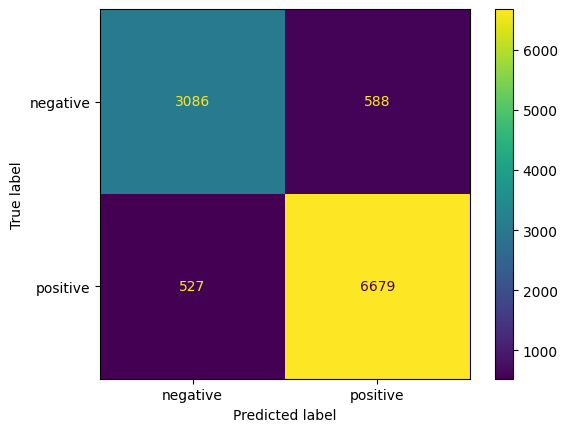

In [119]:
report(best_model)

Hasil serupa dan bahkan sedikit lebih buruk dibandingkan dengan regresi logistik. Masuk akal mengingat kelas dan batasan yang salah diberi label.

In [120]:
df.head()

,text,score,date,app_version,target,target_binery,app_version_cut,text_processed,tokens,tokens_without_stopword,prediction,prediction_confidence
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]",negative,0.794665
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b...",negative,0.544607
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa...",positive,0.637327
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap],positive,0.994920
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus],positive,0.982894


**Model Pembelajaran Mendalam, dengan mempertimbangkan urutan kata dan makna dengan Penyematan.**
Pada titik ini, daripada melanjutkan model pembelajaran mendalam, kita harus kembali ke data dan memberi label ulang pada data tersebut untuk mendapatkan performa yang lebih baik. Jadi pada poin ini dan seterusnya, murni untuk pendidikan saja.


In [124]:
!pip install tensorflow

In [123]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [126]:
# jumlah kelas
K = df['target_binery'].max() + 1
K

2

In [127]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [133]:
MAX_VOCAB_SIZE = 3000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['tokens_without_stopword'])
sequences_train = tokenizer.texts_to_sequences(df_train['tokens_without_stopword'])
sequences_test = tokenizer.texts_to_sequences(df_test['tokens_without_stopword'])

In [134]:
# dapatkan kata -> pemetaan bilangan bulat
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 11877 unique tokens.


In [138]:
# urutan pad untuk mendapatkan matriks N x T
data_train = pad_sequences(sequences_train)
print(f'shape of data train tensor : {data_train.shape}')
# Panjang urutan
T = data_train.shape[1]

shape of data train tensor : (22089, 55)


In [139]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'shape of data test tensor : {data_test.shape}')

shape of data test tensor : (10880, 55)


# RN LSTM

In [141]:
# embedding dimensionality
D = 10
# size of the embedding to (V + 1) x D, because the first index starts from 1 and not 0

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [142]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [143]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 55)]              0         
                                                                 
 embedding (Embedding)       (None, 55, 10)            118780    
                                                                 
 lstm (LSTM)                 (None, 55, 16)            1728      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 120542 (470.87 KB)
Trainable params: 120542 (470.87 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [146]:
print('Training model...')
r = model.fit(
  data_train,
  df_train['target_binery'],
  epochs=5,
  validation_data=(data_test, df_test['target_binery'])
)

Training model...
Epoch 1/5
691/691 [==============================] - 33s 40ms/step - loss: 0.3753 - accuracy: 0.8352 - val_loss: 0.2720 - val_accuracy: 0.8954
Epoch 2/5
691/691 [==============================] - 21s 31ms/step - loss: 0.2454 - accuracy: 0.9076 - val_loss: 0.2425 - val_accuracy: 0.9061
Epoch 3/5
691/691 [==============================] - 24s 34ms/step - loss: 0.2179 - accuracy: 0.9201 - val_loss: 0.2387 - val_accuracy: 0.9064
Epoch 4/5
691/691 [==============================] - 30s 43ms/step - loss: 0.2034 - accuracy: 0.9259 - val_loss: 0.2395 - val_accuracy: 0.9054
Epoch 5/5
691/691 [==============================] - 22s 32ms/step - loss: 0.1945 - accuracy: 0.9305 - val_loss: 0.2397 - val_accuracy: 0.9068


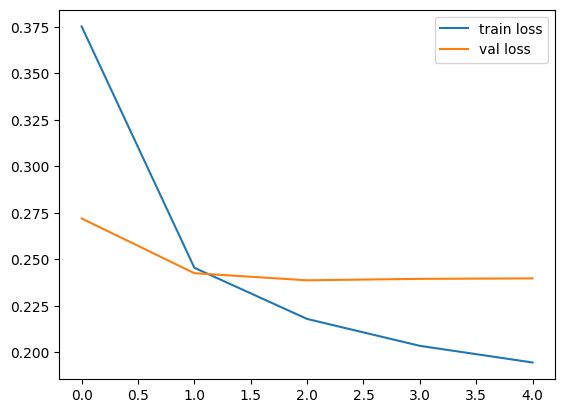

In [147]:
# plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

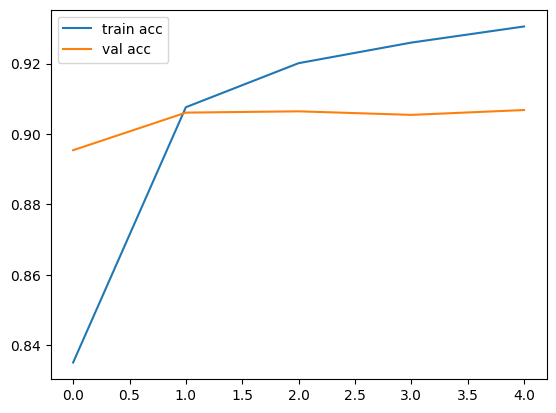

In [148]:
# plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

# CNN

In [149]:
D = 10

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(16, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [150]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 55)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 55, 10)            118780    
                                                                 
 conv1d (Conv1D)             (None, 53, 16)            496       
                                                                 
 global_max_pooling1d_1 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 119310 (466.05 KB)
Trainable params: 119310 (466.05 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [152]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['target_binery'],
  epochs=5,
  validation_data=(data_test, df_test['target_binery'])
)

Training model...
Epoch 1/5
691/691 [==============================] - 12s 13ms/step - loss: 0.3603 - accuracy: 0.8451 - val_loss: 0.2452 - val_accuracy: 0.9059
Epoch 2/5
691/691 [==============================] - 5s 8ms/step - loss: 0.2275 - accuracy: 0.9134 - val_loss: 0.2389 - val_accuracy: 0.9051
Epoch 3/5
691/691 [==============================] - 4s 6ms/step - loss: 0.2059 - accuracy: 0.9238 - val_loss: 0.2407 - val_accuracy: 0.9099
Epoch 4/5
691/691 [==============================] - 7s 10ms/step - loss: 0.1921 - accuracy: 0.9296 - val_loss: 0.2481 - val_accuracy: 0.9050
Epoch 5/5
691/691 [==============================] - 7s 10ms/step - loss: 0.1821 - accuracy: 0.9327 - val_loss: 0.2530 - val_accuracy: 0.9059


Meskipun agak jarang, model CNN dapat digunakan untuk menganalisis teks. Waktu kereta juga jauh lebih cepat karena adanya konvolusi (langkah dan/atau pooling).

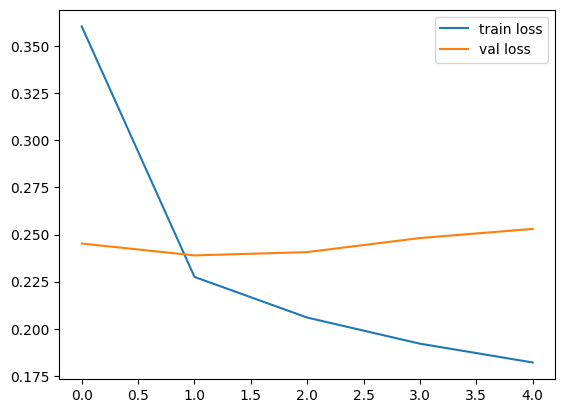

In [153]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

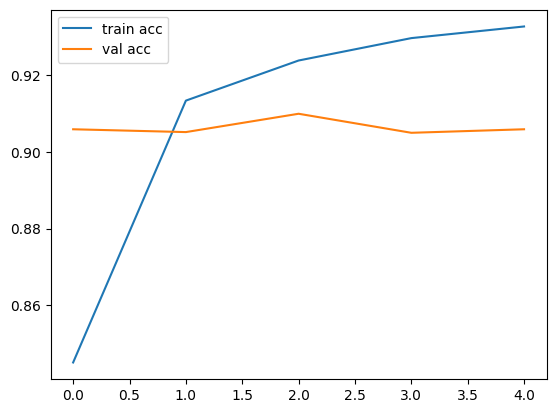

In [154]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

Kedua hasil model dasar tersebut memang tidak berbeda jauh dengan hasil model Regresi Logistik. Hal ini dapat berarti bahwa data tidak cukup kompleks sehingga metode Bag of Word yang sederhana dapat menangkap sentimen. Selain itu, data yang salah label juga perlu diperbaiki terlebih dahulu.

Transfer Learning dan Penyempurnaan Model Bahasa Indonesia Berbasis BERT Fill-Mask BERT
Di atas mengarah ke google colab

tl: dr
Tidak banyak yang terjadi, hanya sekumpulan sintaks yang menyiapkan data agar sesuai dengan model dan 20 menit waktu pelatihan. Alih-alih model akhir, model yang baru saja menyelesaikan epoch ke-2 yang dipilih, yang memiliki akurasi dan f1-score tertinggi, masing-masing 0.92 dan 0.91.